### set folder_name and `num_trials`

In [7]:
name = 'ANB1'
session = '20231030_d5'
num_trials = 183

### imports and plot settings:

In [8]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import scipy.signal as signal
import pickle
import glob # find files in a directory
import re # regex for string parsing

from common.set_matplotlib_settings import set_matplotlib_settings
from common.select_trials import select_hit_trials
from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.make_percent_scaled import make_percent_scaled

### Setup folders

In [9]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

HitMovements_folder = "../Data_Copy/AnalysisData/"+name+"/HitMovements_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/Path_"+name+"_"+session+"/"
!mkdir {output_folder}

respMTX shape: (183, 7)
MTXTrialType shape: (1000, 5)
number of trials: 183
mkdir: ../Data_Copy/AnalysisData/ANB1/Path_ANB1_20231030_d5/: File exists


### Select hit trials

In [10]:
hit_trials = select_hit_trials(respMTX, num_trials)

101  hit trials in this session.


### Make functions scaled from 0-100% of movement path completion to analyze movement path variability
These scaled 0-100% movement path functions are made by linearly interpolating the original data at rates above sampling rate to make an approximate continuous function throughout the path. Right now, the `num_samples` = 10*10000 for a minimum sampling rate of 10kHz since __the movements all take less than 10s__.

Save all of them together in `movements_percent_scaled` and then into "movements_percent_scaled.npy" file.

`movements_percent_scaled`: rows are individual movements, columns are samples (so left to right is going forward in time)

In [11]:
num_interpolation_samples = 10*10000
movements_percent_scaled = make_percent_scaled(hit_trials, num_interpolation_samples, 'movement', HitMovements_folder, output_folder)

percent scaled shape:  (101, 100000)


### Plot the movement paths across % movement completed as the x-axis

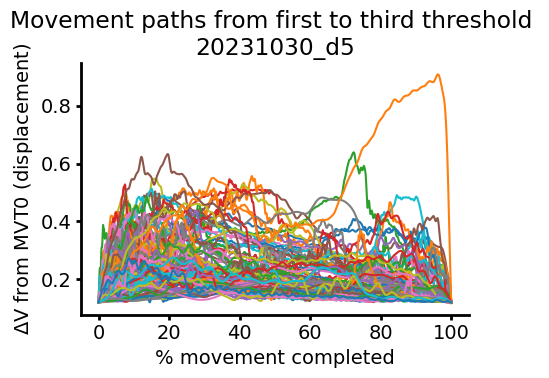

In [12]:
set_matplotlib_settings()

x_range = np.array(range(0, num_interpolation_samples)) *100/num_interpolation_samples

for trial_index in hit_trials:
    movement_percent_scaled = np.load(output_folder+'movement_percent_scaled_trial'+str(trial_index)+'.npy')
    
    plt.plot(x_range, movement_percent_scaled)
plt.xlabel("% movement completed")
plt.ylabel("$\Delta$V from MVT0 (displacement)")
plt.title("Movement paths from first to third threshold \n"+session)
plt.show()

### calculate the movement path variance, `var_p`, across each movement in `movements_percent_scaled`
axis=0 runs downwards across rows

In [13]:
var_p=np.var(movements_percent_scaled, axis=0)

plot `var_p` across % movement completed

Text(0.5, 1.0, 'Variance of movement paths from first to second threshold \n20231030_d5')

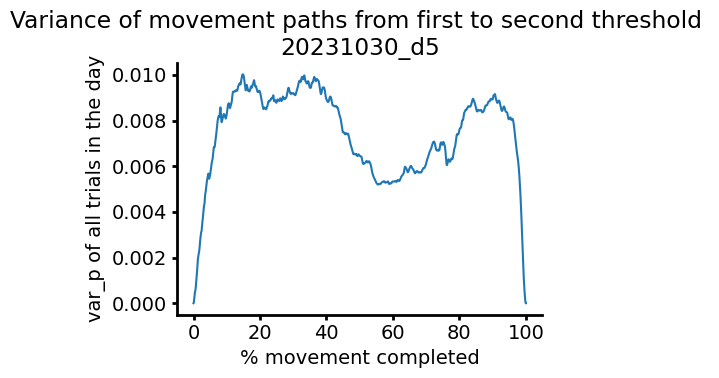

In [14]:
plt.plot(x_range, var_p)
plt.xlabel("% movement completed")
plt.ylabel("var_p of all trials in the day")
plt.title("Variance of movement paths from first to second threshold \n"+session)

### Also calculate the average movement path, `mean_ps`, across each `interpolated_movement_dataArduino`

In [15]:
mean_p=np.mean(movements_percent_scaled, axis=0)

plot `mean_p` across % movement completed

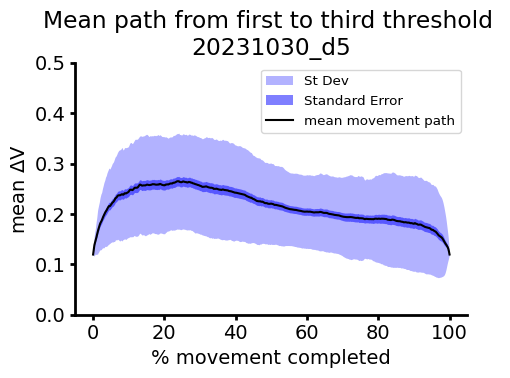

In [16]:
num_movements = len(hit_trials)
std = np.sqrt(var_p)
standard_error = np.sqrt(var_p/num_movements)

plt.fill_between(x_range, mean_p+std, mean_p-std, color='blue', alpha=0.3, label='St Dev', zorder=1, linewidth=0.0)
plt.fill_between(x_range, mean_p+standard_error, mean_p-standard_error, color='blue', alpha=0.5, label='Standard Error', zorder=2, linewidth=0.0)
plt.plot(x_range, mean_p, label="mean movement path", zorder=3, color='black')
plt.xlabel("% movement completed")
plt.ylabel("mean $\Delta$V")
plt.legend()
plt.title("Mean path from first to third threshold \n"+session)
plt.ylim([0, 0.5])
plt.savefig(output_folder + "path" + ".png")


### save `var_p` and `mean_p` to .npy files

In [17]:
np.save(output_folder+'var_p', var_p)
np.save(output_folder+'mean_p', mean_p)
np.save(output_folder+'num_movements', num_movements)